This file is for making the volume weighted graphs during the two deglaciations

# Set up file

In [71]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import sys
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Deglaciation/modules/')
from keyname import keyname as kn
import config
import itertools
import json

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fontsize = 18


# Load Stored Results

In [72]:
# Load the oceanic d13C data
results_dict = json.loads(open("Data/results_dict.json","r").read())

# Load the period definitions
df_periods = pd.DataFrame(config.period_list,columns=['range','name'])

# Create Auxillary functions

In [73]:
def normalising(grid_min,grid_max,grid_value):
    '''Function for normalising the latitude, longitude, or depth value as a fraction of the total for the line colours'''
    # Get the fraction of the total grid domain
    fraction = (grid_value-grid_min)/(grid_max-grid_min)
    
    return(fraction)

# Extract the high resolution cores

In [74]:
# Define the list of basin that you want to look for high res cores in
basin = ['Atlantic']#,'Pacific','Indian']

# Create a dataframe of all the combinations of the time periods and basins
combinations = pd.DataFrame(list(itertools.product(*[config.period_list,basin]))).rename(
    columns={0:'period',1:'basin'})

# Create an empty dictionary to add the d13C by period and basin
d13C_unsliced_dict = {}

# Loop over all the combinations
for period,basin in zip(
    combinations['period'],
    combinations['basin']
    ):
    
    # Get the relevant hashkey
    hashkey_d13C_unsliced = kn(basin=basin,period=period[1],vartype='df_d13C_unsliced')

    # From the results dict, create dataframe for the relevant results using the hashkey
    df_d13C_unsliced = pd.DataFrame.from_dict(results_dict[hashkey_d13C_unsliced])
    
    # Add the dataframe to the dictionary
    d13C_unsliced_dict.update({
        tuple([period[1],basin]) : df_d13C_unsliced
    })
    
# Combine all the dataframes in the same dictionary into a single dataframe
df_d13C_unsliced = pd.concat(d13C_unsliced_dict).reset_index().rename(columns={'level_0':'period','level_1':'basin'}).drop('level_2',axis=1)

# Create a dictionary for storing the number of points per core
number_of_points = {}

# Group the dataframe that contains all the core data by each individual core
for key,group in df_d13C_unsliced.groupby(['Core','period']):
    
    # Find the number of points per core
    number_of_points.update({
        key:len(group)
    })
    
# Create dataframe of the number of points per core, and sort in a descending order. The index on this DF needs fixing
df_number_of_points_temp = pd.DataFrame.from_dict(number_of_points,orient='index',columns=['count']).sort_values(by='count',ascending=False)

# Fix the index on the number of points dataframe using the temp dataframe
df_number_of_points = pd.DataFrame(df_number_of_points_temp.index.to_list()).rename(columns={0:'Core',1:'period'})
df_number_of_points['count'] = df_number_of_points_temp['count'].to_list()

# Select the number of cores to be taken as high res
number_of_cores = 50

# Create an empty dictionary to put the high res cores list into (w.r.t. the time period)
high_res_cores_dict = {}

# Loop over the different periods
for period in np.unique(df_number_of_points.period):
    
    # Get the list of high res cores for this period
    high_res_cores_list = \
        df_number_of_points[df_number_of_points.period==period].head(number_of_cores).Core
    
    # Update the dictionary with the list of high res cores
    high_res_cores_dict.update({
        period : high_res_cores_list
    })



In [76]:
df_d13C_high_res_cores = df_d13C_unsliced[df_d13C_unsliced.Core.isin(high_res_cores_list)]
lat_max = np.max(df_d13C_high_res_cores.Lat)
lat_min = np.min(df_d13C_high_res_cores.Lat)
lon_max = np.max(df_d13C_high_res_cores.Lon)
lon_min = np.min(df_d13C_high_res_cores.Lon)


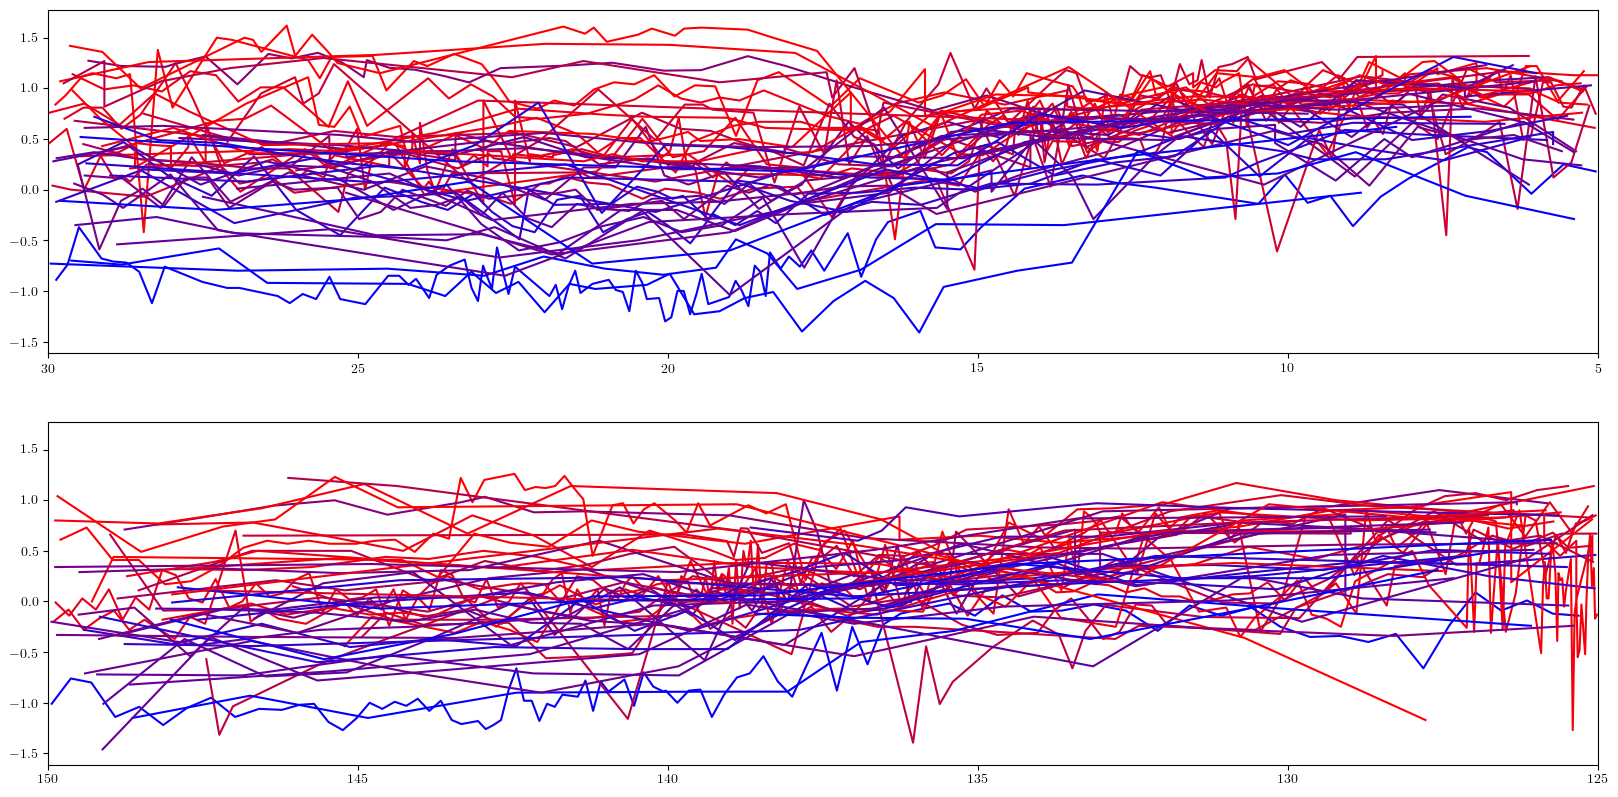

In [77]:

fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

for core in high_res_cores_list:
    df_one_high_res_core = df_d13C_unsliced[df_d13C_unsliced.Core==core]
    for ax in [ax1,ax2]:
        for period,df_one_high_res_core_one_period in df_one_high_res_core.groupby('period'):
                
            # Find an appropriate colour for this core
            core_location = df_one_high_res_core_one_period[['Lat']].head(1).values.tolist()[0]
            core_colour = [normalising(grid_min,grid_max,grid_value) for grid_min,grid_max,grid_value in zip(
                [lat_min,lat_max],[lat_max,lat_min],(core_location+core_location))]
            core_colour = [core_colour[0]]+[0]+[core_colour[-1]]
            core_colour.append(1)
            
            # Plot the line
            ax.plot(df_one_high_res_core_one_period['age'],
                     df_one_high_res_core_one_period['d13C'],
                     c=core_colour)
            
ax1.set_xlim(30,5)
ax2.set_xlim(150,125)
    

plt.show()
print('')

In [63]:
(core_location+core_location)

[49.88, 49.88]

In [42]:
df_one_high_res_core_one_period[['Lat','Lon']].head(1).values.tolist()[0]

[49.88, -24.24]

In [6]:
core_location = df_one_high_res_core_one_period[['Lat','Lon','Dep']].head(1).values
core_colour = [normalising(grid_min,grid_max,grid_value) for grid_min,grid_max,grid_value in zip([-90,-180,1000],[90,180,6000],core_location.tolist()[0])]
core_colour.append(1)

In [7]:
core_colour


[0.25516666666666665, 0.46052777777777776, 0.554, 1]

In [8]:
core_location.tolist()[0]


[-44.07, -14.21, 3770.0]

# Get the Volume Weighted Results from Results Dict

In [9]:
# # Start off by only looking at the Atlantic
# basin=['Atlantic','Pacific']

# # Find all possible combinations of period, location and depth
# combinations = pd.DataFrame(list(itertools.product(*[config.period_list,basin]))).rename(
#     columns={0:'period',1:'basin'})

# # Create a dictionary to store the volume weighted dataframes in
# volume_weighted_dfs_dict = {}

# # Loop over all the combinations
# for period,basin in zip(
#     combinations['period'],
#     combinations['basin']
#     ):
    
#     # Get the hashkey
#     hashkey_avg_age = kn(basin=basin,period=period[1],vartype='d13C_avg_age')
    
#     # Get the dataframe of the relevant results
#     df_avg_age = pd.DataFrame.from_dict(results_dict[hashkey_avg_age])
    
#     volume_weighted_dfs_dict.update({
#         tuple([period[1],basin]) : df_avg_age
#     })
    

# Plot the Results